# **Probability-Based IRTでの能力分析アルゴリズム**

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## ***各パラメータ推定アルゴリズムを関数化***

In [ ]:
D = 1.702  # 標準正規分布に対応させるスケーリング係数

# 項目情報関数の定義
def item_information(a, b, theta):
    p = 1 / (1 + np.exp(-D * a * (theta - b)))
    q = 1 - p
    return D**2 * a**2 * p * q

# 標準誤差の計算用の関数　aはかなり特殊
def standard_error_per_a(a, b, theta):
    info = np.sum([item_information(a, b, t) * (t - b)**2 for t in theta])
    return 1 / np.sqrt(np.clip(info, 1e-6, None))

def standard_error_per_b(a, b, theta):
    info = np.sum(item_information(a, b, theta))
    return 1 / np.sqrt(np.clip(info, 1e-6, None))

def standard_error_per_theta(a, b, theta):
    info = np.sum([item_information(ai, bi, theta) for ai, bi in zip(a, b)])
    return 1 / np.sqrt(np.clip(info, 1e-6, None))

In [ ]:
def Prob_based_2PL_IRT(P_true, max_iter, epsilon):
  # 入力: P_true, ma_iter, epsilon
  # 出力: a, b, theta, a_se, b_se, theta_se

  # theta_hat の初期値を P_true の平均値に基づいて設定
  P_mean_llm = np.mean(P_true, axis=1)
  theta_hat = -2 + 4 * (P_mean_llm - np.min(P_mean_llm)) / (np.max(P_mean_llm) - np.min(P_mean_llm))

  # b_hat の初期値を P_true の列方向の平均値に基づいて設定
  P_mean_item = np.mean(P_true, axis=0)
  b_hat = -2 + 4 * (P_mean_item - np.min(P_mean_item)) / (np.max(P_mean_item) - np.min(P_mean_item))

  # a_hat は一律で 1 に設定
  #a_hat = np.ones(P_true.shape[1])

  # a_hat の初期値を P_true の微分を利用して設定
  a_hat = np.zeros(P_true.shape[1])

  for i in range(P_true.shape[1]):
    sorted_idx = np.argsort(theta_hat)  # theta の小さい順にソート
    sorted_theta = theta_hat[sorted_idx]
    sorted_P = P_true[:, i][sorted_idx]

    # 有限差分法による微分計算（中央差分）
    dP_dtheta = np.gradient(sorted_P, sorted_theta)  # 数値微分

    # P_avg の計算を修正: dP_dtheta と同じ長さにする
    P_avg = (sorted_P[:-1] + sorted_P[1:]) / 2
    P_avg = np.concatenate([P_avg, [P_avg[-1]]]) #最後の要素を複製して長さを合わせる

    # a の近似計算
    a_estimate = dP_dtheta / (D * P_avg * (1 - P_avg))

    # 異常値を排除しながら平均値を計算（極端な値を除外）
    a_hat[i] = np.clip(np.nanmedian(a_estimate), 0.5, 1.5)  # 中央値を利用し、範囲制限

  # 繰り返し回帰
  for iteration in range(max_iter):
      # 現在の値を保存
    a_old, b_old, theta_old = a_hat.copy(), b_hat.copy(), theta_hat.copy()

    # ステップ1: thetaの更新
    for m in range(P_true.shape[0]):
        def neg_ll(theta):
            logits = D * a_hat * (theta - b_hat)
            p = 1 / (1 + np.exp(-logits))
            return np.sum((P_true[m] - p) ** 2)

        result = minimize(neg_ll, theta_hat[m], bounds=[(-4, 4)], method='L-BFGS-B')
        theta_hat[m] = result.x

    # ステップ2: a, b の更新
    for i in range(P_true.shape[1]):
        # 識別力 a と困難度 b を同時に最適化
        def loss_ab(ab):
            a, b = ab
            logits = D * a * (theta_hat - b)
            p = 1 / (1 + np.exp(-logits))
            return np.sum((P_true[:, i] - p) ** 2)

        # 初期値として現在の a_hat[i], b_hat[i] を使用
        initial_ab = [a_hat[i], b_hat[i]]
        bounds = [(0.1, 2.0), (-2.0, 2.0)]  # a と b の範囲
        result_ab = minimize(loss_ab, initial_ab, bounds=bounds, method='L-BFGS-B')

        # 更新
        a_hat[i], b_hat[i] = result_ab.x

        # mean_thetaの標準化を行い、b_hatとa_hatもスケールを合わせる。
        mean_theta = np.mean(theta_hat)
        std_theta = np.std(theta_hat)
        #std_theta = 1
        theta_hat = (theta_hat - mean_theta) / std_theta
        b_hat = b_hat - mean_theta
        a_hat = a_hat * std_theta

    # 収束判定
    max_diff_a = np.max(np.abs(a_hat - a_old))
    max_diff_b = np.max(np.abs(b_hat - b_old))
    max_diff_theta = np.max(np.abs(theta_hat - theta_old))

    print(f"Iteration {iteration + 1}: max_diff_a = {max_diff_a:.6e}, max_diff_b = {max_diff_b:.6e}, max_diff_theta = {max_diff_theta:.6e}")

    if max_diff_a < epsilon and max_diff_b < epsilon and max_diff_theta < epsilon:
        print("収束しました")
        break
  else:
    print("最大反復回数に達しました")

  # 個別の標準誤差を計算
  a_se = np.array([standard_error_per_a(a_hat[i], b_hat[i], theta_hat) for i in range(P_true.shape[1])])
  b_se = np.array([standard_error_per_b(a_hat[i], b_hat[i], theta_hat) for i in range(P_true.shape[1])])
  theta_se = np.array([standard_error_per_theta(a_hat, b_hat, theta_hat[m]) for m in range(P_true.shape[0])])

  # theta の標準誤差を LLM ごとに計算
  #theta_se = np.zeros(P_true.shape[0])
  #for m in range(P_true.shape[0]):
  #  result = minimize(neg_ll, theta_hat[m], bounds=[(-4, 4)], method='L-BFGS-B')
  #  hessian_inv_theta = result.hess_inv.todense()
  #  theta_se[m] = np.sqrt(np.clip(abs(hessian_inv_theta[0, 0]), 1e-6, None))  # 負の値を防ぎつつ計算

  # a, b の標準誤差を 項目ごとに計算
  #a_se = np.zeros(P_true.shape[1])
  #b_se = np.zeros(P_true.shape[1])
  #for i in range(P_true.shape[1]):
  #  final_ab = [a_hat[i], b_hat[i]]
  #  result_ab = minimize(loss_ab, final_ab, bounds=bounds, method='L-BFGS-B')
  #  hessian_inv_ab = result_ab.hess_inv.todense()
  #  a_se[i] = np.sqrt(np.clip(abs(hessian_inv_ab[0, 0]), 1e-6, None))  # a の標準誤差
  #  b_se[i] = np.sqrt(np.clip(abs(hessian_inv_ab[1, 1]), 1e-6, None))  # b の標準誤差

  return a_hat, b_hat, theta_hat, a_se, b_se, theta_se

##**シミュレーションA**
とりあえずパラメータ数を指定して、真の値を再現するかを見る

In [ ]:
# パラメータの設定
np.random.seed(42)
num_llms = 12  # LLMの数
num_items = 20  # 問題数

# 真のパラメータを生成
a_true = np.random.uniform(0.5, 1.5, num_items)  # 識別力
b_true = np.random.uniform(-1.5, 1.5, num_items)  # 困難度
theta_true = np.random.normal(0, 1, num_llms)  # 能力

# 真の正答確率 P_true を計算
P_true = 1 / (1 + np.exp(-D * a_true * (np.outer(theta_true, np.ones(num_items)) - b_true)))

In [ ]:
# 最大反復数と収束判定閾値を定義
max_iter = 5000
epsilon = 2e-4

In [ ]:
a_hat, b_hat, theta_hat, a_se, b_se, theta_se = Prob_based_2PL_IRT(P_true = P_true, max_iter=max_iter, epsilon=epsilon)

<ipython-input-3-c3e268717806>:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta_hat[m] = result.x


Iteration 1: max_diff_a = 1.500000e+00, max_diff_b = 3.278615e+00, max_diff_theta = 1.059599e+00
Iteration 2: max_diff_a = 1.260463e+00, max_diff_b = 1.059924e+00, max_diff_theta = 7.085468e-01
Iteration 3: max_diff_a = 2.000814e-01, max_diff_b = 1.745070e-01, max_diff_theta = 1.619679e-01
Iteration 4: max_diff_a = 5.564786e-02, max_diff_b = 6.922876e-02, max_diff_theta = 5.087818e-02
Iteration 5: max_diff_a = 2.691157e-02, max_diff_b = 3.689268e-02, max_diff_theta = 2.636483e-02
Iteration 6: max_diff_a = 1.318402e-02, max_diff_b = 1.880696e-02, max_diff_theta = 1.328720e-02
Iteration 7: max_diff_a = 6.359838e-03, max_diff_b = 9.101778e-03, max_diff_theta = 6.347688e-03
Iteration 8: max_diff_a = 3.062679e-03, max_diff_b = 4.413447e-03, max_diff_theta = 3.051802e-03
Iteration 9: max_diff_a = 1.460425e-03, max_diff_b = 2.108686e-03, max_diff_theta = 1.465270e-03
Iteration 10: max_diff_a = 6.398599e-04, max_diff_b = 1.023947e-03, max_diff_theta = 7.031512e-04
Iteration 11: max_diff_a = 4.

In [ ]:
a_se

array([0.66851741, 0.54023039, 0.51614634, 0.56315638, 0.76730979,
       0.60247327, 0.71599726, 0.63817385, 0.65802668, 0.55092348,
       0.80779993, 0.52538202, 0.56148231, 0.51369405, 0.51329755,
       0.58231113, 0.62268374, 0.53226882, 0.62992997, 0.68838344])

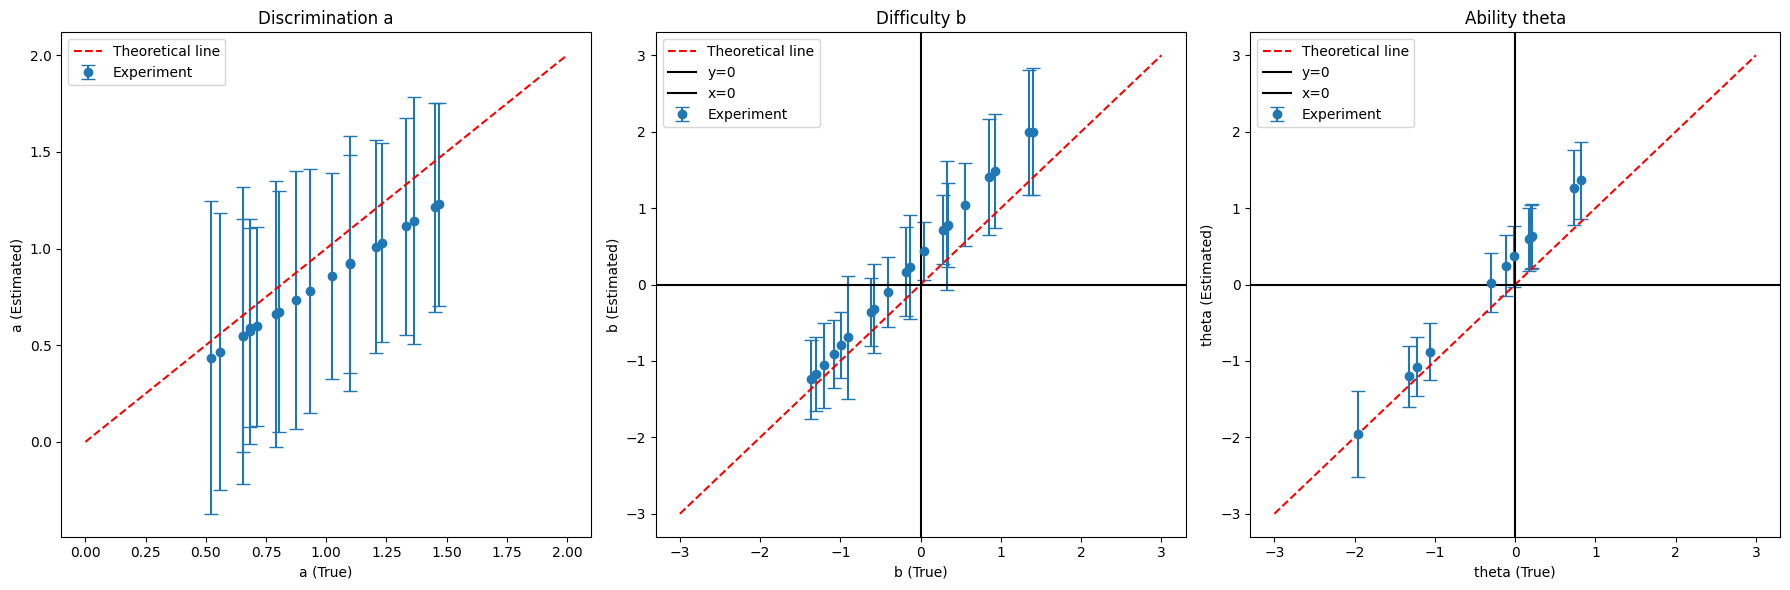

In [ ]:
# Plotting
plt.figure(figsize=(18, 6))

# Discrimination a Plot
plt.subplot(1, 3, 1)
plt.errorbar(a_true, a_hat, yerr=a_se, fmt='o', capsize=5, label='Experiment')
plt.plot([0, 2], [0, 2], 'r--', label='Theoretical line')
plt.xlabel('a (True)')
plt.ylabel('a (Estimated)')
plt.title('Discrimination a')
plt.legend()

# Difficulty b Plot
plt.subplot(1, 3, 2)
plt.errorbar(b_true, b_hat, yerr=b_se, fmt='o', capsize=5, label='Experiment')
plt.plot([-3, 3], [-3, 3], 'r--', label='Theoretical line')
plt.axhline(0, color='black', linestyle='-', label='y=0')
plt.axvline(0, color='black', linestyle='-', label='x=0')
plt.xlabel('b (True)')
plt.ylabel('b (Estimated)')
plt.title('Difficulty b')
plt.legend()

# Ability theta Plot
plt.subplot(1, 3, 3)
plt.errorbar(theta_true, theta_hat, yerr=theta_se, fmt='o', capsize=5, label='Experiment')
plt.plot([-3, 3], [-3, 3], 'r--', label='Theoretical line')
plt.axhline(0, color='black', linestyle='-', label='y=0')
plt.axvline(0, color='black', linestyle='-', label='x=0')
plt.xlabel('theta (True)')
plt.ylabel('theta (Estimated)')
plt.title('Ability theta')
plt.legend()

plt.tight_layout()
plt.show()

##**シミュレーションB**
問題数を振りながら、標準誤差がどう変化するかをつかむ

In [ ]:
# 真のパラメータを生成からシミュレーションまでを一体化
def simulate_and_SE_estimate(num_llms, num_items, max_iter, epsilon):
  # 出力:a_se_mean_squared, b_se_mean_squared, theta_se_mean_squared
  # 真のパラメータを生成
  a_true = np.random.uniform(0.5, 1.5, num_items)  # 識別力
  b_true = np.random.uniform(-1.5, 1.5, num_items)  # 困難度
  theta_true = np.random.normal(0, 1, num_llms)  # 能力
  # 真の正答確率 P_true を計算
  P_true = 1 / (1 + np.exp(-D * a_true * (np.outer(theta_true, np.ones(num_items)) - b_true)))
  # 最大反復数と収束判定閾値を定義
  a_hat, b_hat, theta_hat, a_se, b_se, theta_se = Prob_based_2PL_IRT(P_true = P_true, max_iter=max_iter, epsilon=epsilon)
  a_se_mean_squared = np.sqrt(np.mean(a_se**2))
  b_se_mean_squared = np.sqrt(np.mean(b_se**2))
  theta_se_mean_squared = np.sqrt(np.mean(theta_se**2))
  return a_se_mean_squared, b_se_mean_squared, theta_se_mean_squared

In [ ]:
# パラメータの設定
np.random.seed(42)
num_llms = 100  # LLMの数（ここは固定とする）
num_items_pattern = [10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]  # 問題数の候補
max_iter = 5000
epsilon = 2e-4

In [ ]:
a_se_mean_squared_list = []
b_se_mean_squared_list = []
theta_se_mean_squared_list = []

for num_items in num_items_pattern:
  print(f"num_items = {num_items}")
  a_se_mean_squared, b_se_mean_squared, theta_se_mean_squared = simulate_and_SE_estimate(num_llms=num_llms, num_items=num_items, max_iter=max_iter, epsilon=epsilon)
  a_se_mean_squared_list.append(a_se_mean_squared)
  b_se_mean_squared_list.append(b_se_mean_squared)
  theta_se_mean_squared_list.append(theta_se_mean_squared)

num_items = 10


<ipython-input-27-c3e268717806>:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta_hat[m] = result.x


Iteration 1: max_diff_a = 1.177558e+00, max_diff_b = 4.856446e+00, max_diff_theta = 1.099992e+00
Iteration 2: max_diff_a = 7.269165e-01, max_diff_b = 1.682012e+00, max_diff_theta = 1.431246e+00
Iteration 3: max_diff_a = 4.519537e-01, max_diff_b = 4.722753e-01, max_diff_theta = 3.679499e-01
Iteration 4: max_diff_a = 2.515914e-01, max_diff_b = 8.606336e-02, max_diff_theta = 2.587655e-01
Iteration 5: max_diff_a = 1.158309e-01, max_diff_b = 3.965583e-02, max_diff_theta = 9.819053e-02
Iteration 6: max_diff_a = 5.629585e-02, max_diff_b = 1.489609e-02, max_diff_theta = 3.302146e-02
Iteration 7: max_diff_a = 2.834367e-02, max_diff_b = 5.456749e-03, max_diff_theta = 1.502550e-02
Iteration 8: max_diff_a = 1.525904e-02, max_diff_b = 3.070433e-03, max_diff_theta = 8.094283e-03
Iteration 9: max_diff_a = 8.449796e-03, max_diff_b = 1.749652e-03, max_diff_theta = 4.665885e-03
Iteration 10: max_diff_a = 4.717901e-03, max_diff_b = 9.948228e-04, max_diff_theta = 2.658930e-03
Iteration 11: max_diff_a = 2.

In [ ]:
a_se_mean_squared_list

[0.20124761026999025,
 0.21390385274561052,
 0.20812129468651128,
 0.2058058385656373,
 0.2009648260571954,
 0.21169034011865365,
 0.2040910448631264,
 0.2068010256286643,
 0.2089905487596096,
 0.20581759742613123,
 0.20497374936547683,
 0.2033248853603593,
 0.20270470483675665,
 0.2072226916857425,
 0.21393279851849192]

In [ ]:
b_se_mean_squared_list

[0.16163576605744656,
 0.19196441049818827,
 0.1793419239191896,
 0.17453044873259013,
 0.1792535992503981,
 0.17368183715350077,
 0.17199571666166139,
 0.18518631860163498,
 0.18162209929307513,
 0.16630248079248464,
 0.16768925611148416,
 0.1650673510834608,
 0.17615796220124585,
 0.18478767171798652,
 0.19768301286450837]

In [ ]:
theta_se_mean_squared_list

[0.5621590670723563,
 0.4281350563726991,
 0.3218911114402425,
 0.2807922476012527,
 0.24407861791908367,
 0.23943744056784458,
 0.20032552488559982,
 0.19656641322864646,
 0.18502313101551554,
 0.16747155346799622,
 0.14961406011009865,
 0.138322088333125,
 0.13381731709307879,
 0.13004758033082897,
 0.13626130051718563]

In [ ]:
num_items_pattern

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]

In [ ]:
error_data_A = {
    'num_items_pattern': num_items_pattern,
    'a_se_mean_squared_list': a_se_mean_squared_list,
    'b_se_mean_squared_list': b_se_mean_squared_list,
    'theta_se_mean_squared_list': theta_se_mean_squared_list
}

In [ ]:
df_error_data_A = pd.DataFrame(error_data_A)

In [ ]:
df_error_data_A

,num_items_pattern,a_se_mean_squared_list,b_se_mean_squared_list,theta_se_mean_squared_list
0,10,0.201248,0.161636,0.562159
1,20,0.213904,0.191964,0.428135
2,30,0.208121,0.179342,0.321891
3,40,0.205806,0.174530,0.280792
4,50,0.200965,0.179254,0.244079
5,60,0.211690,0.173682,0.239437
6,70,0.204091,0.171996,0.200326
7,80,0.206801,0.185186,0.196566
8,90,0.208991,0.181622,0.185023
9,100,0.205818,0.166302,0.167472


In [ ]:
df_error_data_A.to_csv('std_error_A_numllm100.csv', index=False)

## **シミュレーションC**
LLMの数を振りながら、標準偏差がどう変化するかをつかむ

In [ ]:
# パラメータの設定
np.random.seed(42)
num_llms_pattern = [10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]   # LLMの数の候補
num_items = 100 # 問題数(ここは固定とする)
max_iter = 5000
epsilon = 2e-4

In [ ]:
a_se_mean_squared_list = []
b_se_mean_squared_list = []
theta_se_mean_squared_list = []

for num_llms in num_llms_pattern:
  print(f"num_items = {num_llms}")
  a_se_mean_squared, b_se_mean_squared, theta_se_mean_squared = simulate_and_SE_estimate(num_llms=num_llms, num_items=num_items, max_iter=max_iter, epsilon=epsilon)
  a_se_mean_squared_list.append(a_se_mean_squared)
  b_se_mean_squared_list.append(b_se_mean_squared)
  theta_se_mean_squared_list.append(theta_se_mean_squared)

num_items = 10


<ipython-input-27-c3e268717806>:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta_hat[m] = result.x


Iteration 1: max_diff_a = 1.500000e+00, max_diff_b = 4.088865e+00, max_diff_theta = 8.287478e-01
Iteration 2: max_diff_a = 1.286444e+00, max_diff_b = 4.697803e-01, max_diff_theta = 2.255884e-01
Iteration 3: max_diff_a = 6.738629e-01, max_diff_b = 9.656018e-02, max_diff_theta = 1.505915e-01
Iteration 4: max_diff_a = 3.303329e-01, max_diff_b = 7.241151e-02, max_diff_theta = 1.173114e-01
Iteration 5: max_diff_a = 1.967903e-01, max_diff_b = 5.709945e-02, max_diff_theta = 9.461314e-02
Iteration 6: max_diff_a = 1.248669e-01, max_diff_b = 4.110496e-02, max_diff_theta = 7.096146e-02
Iteration 7: max_diff_a = 7.752510e-02, max_diff_b = 2.848516e-02, max_diff_theta = 4.954476e-02
Iteration 8: max_diff_a = 4.853270e-02, max_diff_b = 2.015113e-02, max_diff_theta = 3.355169e-02
Iteration 9: max_diff_a = 3.081124e-02, max_diff_b = 1.407123e-02, max_diff_theta = 2.242862e-02
Iteration 10: max_diff_a = 1.979782e-02, max_diff_b = 9.752053e-03, max_diff_theta = 1.490923e-02
Iteration 11: max_diff_a = 1.

In [ ]:
a_se_mean_squared_list

[0.6646590721882609,
 0.4713641924209632,
 0.37867316425223946,
 0.3266873230177177,
 0.2942203350551965,
 0.27214390980227066,
 0.25465369963431206,
 0.23132833245248605,
 0.21611526019313593,
 0.2090932247670858,
 0.1918987764153427,
 0.17681781452582412,
 0.16263631123257988,
 0.15129583537267532,
 0.1465149265524084]

In [ ]:
b_se_mean_squared_list

[0.6204565034132973,
 0.5312313434356138,
 0.31834898489158425,
 0.29306729703009043,
 0.28991671493213184,
 0.23221951734258053,
 0.2275142173942965,
 0.18597588888984679,
 0.1948866157530925,
 0.1812076880608399,
 0.17074857921013867,
 0.15169546409605802,
 0.12879374806415866,
 0.12411811089624021,
 0.12261003960155818]

In [ ]:
theta_se_mean_squared_list

[0.1816941064005198,
 0.21251741305243324,
 0.16409013825555235,
 0.17534423143192662,
 0.1920965584276086,
 0.1778008542360758,
 0.18458594557413024,
 0.1739848200128371,
 0.17629483903549645,
 0.18311047135635902,
 0.17947090973183602,
 0.17474887831627278,
 0.1795336414843088,
 0.1642805697312618,
 0.17185753057480296]

In [ ]:
num_llms_pattern

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]

In [ ]:
error_data_B = {
    'num_llms_pattern': num_llms_pattern,
    'a_se_mean_squared_list': a_se_mean_squared_list,
    'b_se_mean_squared_list': b_se_mean_squared_list,
    'theta_se_mean_squared_list': theta_se_mean_squared_list
}

In [ ]:
df_error_data_B = pd.DataFrame(error_data_B)

In [ ]:
df_error_data_B

,num_llms_pattern,a_se_mean_squared_list,b_se_mean_squared_list,theta_se_mean_squared_list
0,10,0.664659,0.620457,0.181694
1,20,0.471364,0.531231,0.212517
2,30,0.378673,0.318349,0.164090
3,40,0.326687,0.293067,0.175344
4,50,0.294220,0.289917,0.192097
5,60,0.272144,0.232220,0.177801
6,70,0.254654,0.227514,0.184586
7,80,0.231328,0.185976,0.173985
8,90,0.216115,0.194887,0.176295
9,100,0.209093,0.181208,0.183110


In [ ]:
df_error_data_B.to_csv('std_error_B_numitem100.csv', index=False)

## **政策研究のデータで実際に推定**

In [ ]:
Probability_table_pd = pd.read_csv('/content/250201_STI_policy_quiz_LLM.csv', index_col=0, header=0)

In [ ]:
Probability_table_pd

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20
model,,,,,,,,,,,,,,,,,,,,
Response_model_6,0.028874,0.169361,0.000000,0.000000,1.027875e-03,0.000000,0.723170,0.000000,0.000000,4.896638e-02,0.000000,0.985083,0.000944,0.993848,0.023004,0.116626,0.991972,0.359612,0.668672,0.000000
Response_model_8,0.003700,0.173847,0.413973,0.059553,4.572740e-04,0.066215,0.926865,0.003191,0.000000,5.727950e-01,0.006185,0.999344,0.000000,0.998509,0.015480,0.551130,0.927431,0.205632,0.953543,0.019180
Response_model_10,0.908160,0.004504,0.999004,0.000000,5.683910e-04,0.000000,0.000000,0.001225,0.480645,9.933189e-01,0.000000,0.587490,0.300794,0.993798,0.676522,0.001333,0.996984,0.820832,0.057039,0.926901
Response_model_11,0.999989,0.004380,0.987528,0.031781,6.079900e-04,0.000086,0.853934,0.000072,0.031803,3.739303e-02,0.820629,0.999992,0.990495,0.999988,0.989083,0.506385,0.999999,0.218064,0.998895,0.999124
Response_model_13,0.998759,0.003782,0.014551,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.137375,0.000000e+00,0.000000,0.000000,0.043510,0.999129,0.912710,0.372834,0.999993,0.000000,0.000000,0.000000
Response_model_14,0.944800,0.007246,0.999895,0.000583,0.000000e+00,0.045963,0.538833,0.000048,0.008760,5.923028e-01,0.000000,0.999769,0.020993,0.997724,0.300455,0.152068,0.999620,0.716470,0.598263,0.774992
Response_model_15,0.939696,0.006247,0.999928,0.000079,0.000000e+00,0.000000,0.549864,0.000000,0.040926,5.200616e-01,0.000000,0.999780,0.022339,0.996132,0.409893,0.263122,0.999688,0.351529,0.364177,0.921862
Response_model_16,1.000000,0.000005,0.999983,0.547715,8.880000e-07,0.995262,0.999999,0.994854,0.088296,4.410000e-08,0.999394,1.000000,0.999942,1.000000,0.999998,0.999232,0.999986,0.983128,1.000000,0.999949
Response_model_18,0.314074,0.133149,0.003864,0.529203,4.166169e-01,0.000126,0.208679,0.002081,0.995854,2.510000e-05,0.039975,1.000000,0.999994,1.000000,0.295199,0.886539,1.000000,0.932160,0.969886,0.999972


In [ ]:
Probability_table = Probability_table_pd.to_numpy()

In [ ]:
Probability_table

array([[2.88743280e-02, 1.69360870e-01, 0.00000000e+00, 0.00000000e+00,
        1.02787500e-03, 0.00000000e+00, 7.23170060e-01, 0.00000000e+00,
        0.00000000e+00, 4.89663810e-02, 0.00000000e+00, 9.85083321e-01,
        9.43933000e-04, 9.93847886e-01, 2.30043840e-02, 1.16626163e-01,
        9.91971769e-01, 3.59611681e-01, 6.68671540e-01, 0.00000000e+00],
       [3.70024400e-03, 1.73847332e-01, 4.13973496e-01, 5.95534280e-02,
        4.57274000e-04, 6.62147280e-02, 9.26865398e-01, 3.19065900e-03,
        0.00000000e+00, 5.72794973e-01, 6.18487900e-03, 9.99343991e-01,
        0.00000000e+00, 9.98509140e-01, 1.54803060e-02, 5.51130158e-01,
        9.27430889e-01, 2.05632060e-01, 9.53543349e-01, 1.91800140e-02],
       [9.08159744e-01, 4.50373900e-03, 9.99003795e-01, 0.00000000e+00,
        5.68391000e-04, 0.00000000e+00, 0.00000000e+00, 1.22530300e-03,
        4.80644575e-01, 9.93318897e-01, 0.00000000e+00, 5.87490078e-01,
        3.00794452e-01, 9.93798047e-01, 6.76521565e-01, 1.3327

In [ ]:
# 最大反復数と収束判定閾値を定義
max_iter = 5000
epsilon = 1e-4

In [ ]:
a, b, theta, a_se, b_se, theta_se = Prob_based_2PL_IRT(P_true = Probability_table, max_iter=max_iter, epsilon=epsilon)

<ipython-input-27-c3e268717806>:32: RuntimeWarning: invalid value encountered in divide
  a_estimate = dP_dtheta / (D * P_avg * (1 - P_avg))
<ipython-input-27-c3e268717806>:32: RuntimeWarning: divide by zero encountered in divide
  a_estimate = dP_dtheta / (D * P_avg * (1 - P_avg))
<ipython-input-27-c3e268717806>:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta_hat[m] = result.x


Iteration 1: max_diff_a = 5.576522e+00, max_diff_b = 4.000000e+00, max_diff_theta = 9.744936e-01
Iteration 2: max_diff_a = 6.661802e+00, max_diff_b = 3.382836e+00, max_diff_theta = 5.213694e-01
Iteration 3: max_diff_a = 1.014122e+00, max_diff_b = 4.888735e-01, max_diff_theta = 1.731198e-01
Iteration 4: max_diff_a = 1.604536e-01, max_diff_b = 1.318459e-01, max_diff_theta = 1.289207e-01
Iteration 5: max_diff_a = 6.549350e-02, max_diff_b = 5.814817e-02, max_diff_theta = 5.453786e-02
Iteration 6: max_diff_a = 5.250184e-02, max_diff_b = 2.890169e-02, max_diff_theta = 3.222290e-02
Iteration 7: max_diff_a = 3.651149e-02, max_diff_b = 1.497326e-02, max_diff_theta = 1.901663e-02
Iteration 8: max_diff_a = 2.360400e-02, max_diff_b = 7.902219e-03, max_diff_theta = 1.079231e-02
Iteration 9: max_diff_a = 1.458881e-02, max_diff_b = 4.224789e-03, max_diff_theta = 6.071219e-03
Iteration 10: max_diff_a = 8.828166e-03, max_diff_b = 2.294158e-03, max_diff_theta = 3.423869e-03
Iteration 11: max_diff_a = 5.

In [ ]:
a_se

array([0.57681487, 0.75300406, 0.64050785, 0.58880677, 0.75300406,
       0.70215229, 0.74315777, 0.72530437, 0.71745318, 0.79202257,
       0.60856564, 0.77256899, 0.5398455 , 0.79222482, 0.61182141,
       0.56728462, 0.79222482, 0.69969481, 0.59268357, 0.63148127])

In [ ]:
b_se

array([0.66652623, 0.57909576, 0.30569247, 0.51975508, 0.57909576,
       0.28419115, 0.80698631, 0.29129814, 1.06548558, 1.67184587,
       0.30026099, 0.35005385, 0.30943325, 0.53147159, 0.55724946,
       0.48285216, 0.53147159, 0.67353076, 0.58705668, 0.29704009])

In [ ]:
theta_se

array([0.31994943, 0.31663524, 0.3451392 , 0.33288719, 0.32020305,
       0.34037566, 0.34077779, 0.34716838, 0.35130475, 0.31443299,
       0.32720891, 0.31200215])

In [ ]:
#項目パラメータとthetaをそれぞれ別々にcsvに落とす。
para = pd.DataFrame([a, a_se, b, b_se], columns = Probability_table_pd.columns, index = ['a_estimated','a_SE','b_estimated','b_SE'])

Probability_table_and_theta = Probability_table_pd.copy()
Probability_table_and_theta['theta'] = theta
Probability_table_and_theta['theta_se'] = theta_se

para.to_csv('para.csv', index=False)
Probability_table_and_theta.to_csv('probability_table_and_theta.csv', index=False)

In [ ]:
Probability_table_and_theta

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,theta,theta_se
model,,,,,,,,,,,,,,,,,,,,,
Response_model_6,0.028874,0.169361,0.000000,0.000000,1.027875e-03,0.000000,0.723170,0.000000,0.000000,4.896638e-02,...,0.000944,0.993848,0.023004,0.116626,0.991972,0.359612,0.668672,0.000000,-1.303914,0.319949
Response_model_8,0.003700,0.173847,0.413973,0.059553,4.572740e-04,0.066215,0.926865,0.003191,0.000000,5.727950e-01,...,0.000000,0.998509,0.015480,0.551130,0.927431,0.205632,0.953543,0.019180,-1.077293,0.316635
Response_model_10,0.908160,0.004504,0.999004,0.000000,5.683910e-04,0.000000,0.000000,0.001225,0.480645,9.933189e-01,...,0.300794,0.993798,0.676522,0.001333,0.996984,0.820832,0.057039,0.926901,-0.414800,0.345139
Response_model_11,0.999989,0.004380,0.987528,0.031781,6.079900e-04,0.000086,0.853934,0.000072,0.031803,3.739303e-02,...,0.990495,0.999988,0.989083,0.506385,0.999999,0.218064,0.998895,0.999124,0.553433,0.332887
Response_model_13,0.998759,0.003782,0.014551,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.137375,0.000000e+00,...,0.043510,0.999129,0.912710,0.372834,0.999993,0.000000,0.000000,0.000000,-1.626178,0.320203
Response_model_14,0.944800,0.007246,0.999895,0.000583,0.000000e+00,0.045963,0.538833,0.000048,0.008760,5.923028e-01,...,0.020993,0.997724,0.300455,0.152068,0.999620,0.716470,0.598263,0.774992,-0.489324,0.340376
Response_model_15,0.939696,0.006247,0.999928,0.000079,0.000000e+00,0.000000,0.549864,0.000000,0.040926,5.200616e-01,...,0.022339,0.996132,0.409893,0.263122,0.999688,0.351529,0.364177,0.921862,-0.483459,0.340778
Response_model_16,1.000000,0.000005,0.999983,0.547715,8.880000e-07,0.995262,0.999999,0.994854,0.088296,4.410000e-08,...,0.999942,1.000000,0.999998,0.999232,0.999986,0.983128,1.000000,0.999949,1.509416,0.347168
Response_model_18,0.314074,0.133149,0.003864,0.529203,4.166169e-01,0.000126,0.208679,0.002081,0.995854,2.510000e-05,...,0.999994,1.000000,0.295199,0.886539,1.000000,0.932160,0.969886,0.999972,0.290169,0.351305


In [ ]:
para

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20
a_estimated,0.644673,2.000000,2.000000,0.946327,2.000000,2.000000,0.462674,2.000000,0.353766,0.219539,1.851212,2.000000,2.000000,2.000000,0.717529,0.861980,2.000000,0.562109,0.713484,2.000000
a_SE,0.576815,0.753004,0.640508,0.588807,0.753004,0.702152,0.743158,0.725304,0.717453,0.792023,0.608566,0.772569,0.539845,0.792225,0.611821,0.567285,0.792225,0.699695,0.592684,0.631481
b_estimated,-1.236498,2.000000,-0.962369,1.339456,2.000000,0.960609,-0.695902,1.106669,1.354571,2.000000,0.628120,-1.501140,-0.067468,-2.000000,-0.386284,-0.027343,-2.000000,-0.373029,-0.891099,-0.784711
b_SE,0.666526,0.579096,0.305692,0.519755,0.579096,0.284191,0.806986,0.291298,1.065486,1.671846,0.300261,0.350054,0.309433,0.531472,0.557249,0.482852,0.531472,0.673531,0.587057,0.297040
